In [1]:
import os
import pandas as pd
import json
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

한글 깨짐 방지

In [2]:
matplotlib.rc('font', family='NanumBarunGothic')

## 1. Top 10 걸음수 그래프 그리기
데이터의 기간과 데이터가 있는 경로를 정하고 데이터를 저장할 데이터프레임을 만듭니다.

In [3]:
dates = pd.date_range('20160401', '20160520').strftime('%Y%m%d')
directory_path = 'sokulee/'
df_steps = pd.DataFrame(index=dates)
df_steps.head()

""
20160401
20160402
20160403
20160404
20160405


1~100번 유저에 대해 해당 유저의 디렉토리가 존재하면 날짜별 steps.json파일을 읽어 총 걸음수를 저장합니다.

In [4]:
for n in range(1,100):
    name = 'A0' + str(n)
    directory_name = directory_path + name
    total_steps = list()

    if os.path.exists(directory_name):
        for date in dates:
            f_steps_path = directory_name + '/' + name + '_' + date + '_steps.json'

            try : 
                f_steps = open(f_steps_path)
            except IOError as e:
                total_steps.append(0)
            else:
                data_steps = json.loads(f_steps.read())

                try :
                    total_steps.append(int(data_steps['activities-steps'][0]['value']))
                except KeyError as e:
                    total_steps.append(0)

        df_steps[name] = total_steps
df_steps.head()

,A01,A02,A03,A04,A05,A06,A07,A08,A010,A016,...,A080,A081,A083,A084,A092,A093,A094,A096,A097,A098
20160401,13468,5877,9282,15263,10805,17250,17993,0,4296,20006,...,15654,12859,11970,17038,20023,11040,13572,12123,2342,0
20160402,9446,4109,9255,8080,472,19239,2856,6750,640,24004,...,8358,4413,7766,6914,2557,3334,5975,15756,8278,0
20160403,6084,5447,7447,6144,1258,15678,8058,14115,2096,11467,...,1059,3412,13763,23013,6144,9984,13565,1044,472,0
20160404,20283,12388,6140,22445,21992,32130,19785,22755,8213,16742,...,15038,10019,13018,14963,11401,13613,20958,21494,10216,0
20160405,12881,7755,10926,17673,26202,19950,17620,12980,12402,20022,...,11730,6736,14583,6792,15548,16839,12058,17585,6223,0


각 유저의 날짜별 총 걸음수를 더해 유저ID를 인덱스로 하는 데이터프레임에 저장합니다.

In [5]:
df_total_steps = pd.DataFrame(data=df_steps.sum(axis=0), index=df_steps.columns, columns=['total_steps'])
df_total_steps.head()

,total_steps
A01,351518
A02,317873
A03,391302
A04,667043
A05,205815


총 걸음수를 내림차순으로 정렬합니다.

In [6]:
df_total_steps.sort_values(by=['total_steps'], inplace=True, ascending=False)
df_total_steps.head()

,total_steps
A025,1083320
A026,1070291
A043,974336
A045,835907
A062,816567


상위 10개를 뽑아 top 10 걸음수를 만듭니다.

In [7]:
top10_steps = df_total_steps[:10]
top10_steps

,total_steps
A025,1083320
A026,1070291
A043,974336
A045,835907
A062,816567
A054,810861
A083,802587
A019,802587
A018,800509
A038,775284


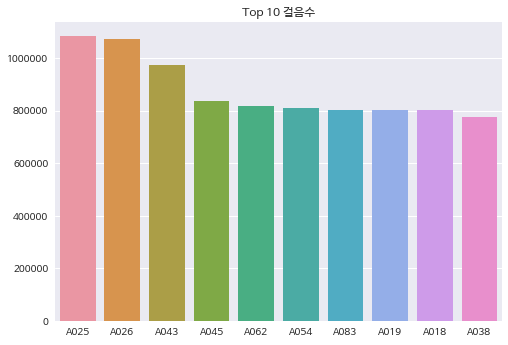

In [8]:
sns.barplot(x=top10_steps.index, y='total_steps', data=top10_steps)
plt.title('Top 10 걸음수')
plt.ylabel('')
plt.show()

## 2. 아침형 인간과 야행성 인간 구별하기
각 유저의 날짜별 sleep.json파일을 읽어서 잠든 시간과 일어난 시간의 평균을 냅니다.<br>
10시 이전에 잠든 경우는 평균을 00시에 가깝게 하기 위해 24를 더해준 값으로 평균을 냅니다.<br>
평균 시간이 24를 넘는 경우 24를 빼줍니다.

In [9]:
df_sleep = pd.DataFrame()
names = list()
start_sleep_mean = list()
end_sleep_mean = list()

for n in range(1,100):
    name = 'A0' + str(n)
    directory_name = directory_path + name
    start_sleep = list()
    end_sleep = list()

    if os.path.exists(directory_name):
        names.append(name)

        for date in dates:
            f_sleep_path = directory_name + '/' + name + '_' + date + '_sleep.json'
            try: 
                f_sleep = open(f_sleep_path)
            except IOError as e:
                continue
            else:
                json_sleep = json.loads(f_sleep.read())
                try: 
                    data_sleep = json_sleep['sleep']
                except KeyError as e:
                    continue
                except IndexError as e:
                    continue
                else:
                    prev_time_to_wake_up = -10 # init prev_time_to_wake_up
                    for t in data_sleep:
                        time_to_sleep = int(t['minuteData'][0]['dateTime'][:2])
                        time_to_wake_up = int(t['minuteData'][-1]['dateTime'][:2])

                        if time_to_sleep <= 10:
                            time_to_sleep += 24

                        if time_to_sleep - prev_time_to_wake_up <= 2:
                            end_sleep[len(end_sleep)-1] = time_to_wake_up
                        else:
                            start_sleep.append(time_to_sleep)
                            end_sleep.append(time_to_wake_up)

                        prev_time_to_wake_up = time_to_wake_up

        mean_time_to_sleep = sum(start_sleep)/len(start_sleep)
        mean_time_to_wake_up = sum(end_sleep)/len(end_sleep)
        if mean_time_to_sleep >= 24:
            mean_time_to_sleep -= 24
        start_sleep_mean.append(mean_time_to_sleep)
        end_sleep_mean.append(mean_time_to_wake_up)

df_sleep['start'] = start_sleep_mean
df_sleep['end'] = end_sleep_mean
df_sleep.index = names
df_sleep.head()


,start,end
A01,23.705882,10.441176
A02,23.000000,11.482759
A03,1.280000,8.800000
A04,1.473684,10.017544
A05,0.250000,6.750000


대부분이 새벽 0시 ~ 3시 사이에 자고, 아침 9시 ~ 11시에 일어나는 것을 확인할 수 있습니다.

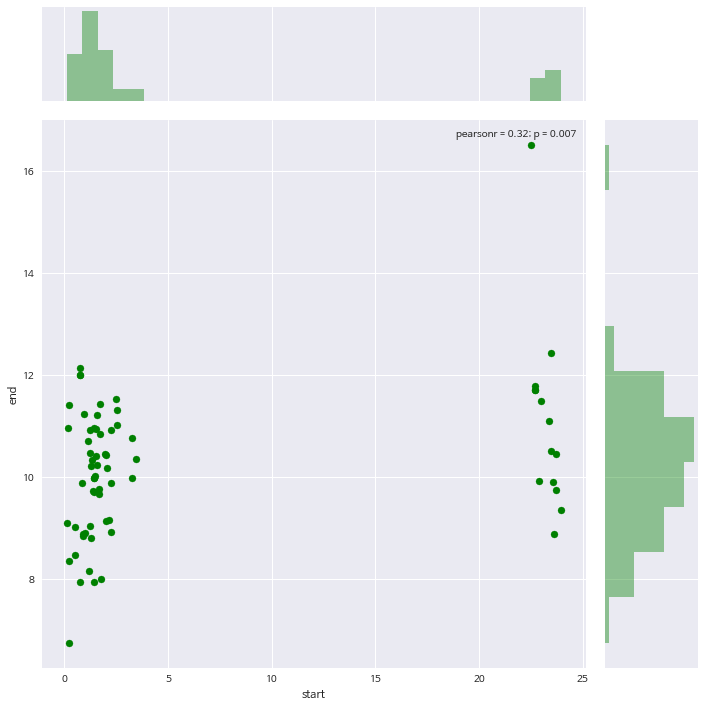

In [10]:
sns.jointplot(x='start', y='end', data=df_sleep, size=10, color="g")
plt.show()